Przedmiot: Podstawy reprezentacji i analizy danych

Tytuł projektu: Klasyfikacja diamentów

Data: 31.01.2021r.

Skład zespołu nr 14:
* Mateusz Kawka
* Bartosz Mazur
* Kacper Tarłowski


**Przedstawienie problemu**

Celem projektu jest klasyfikacja obiektów ze zbioru danych Diamenty. Zbiór ten zawiera około 54000 diamentów opisanych przez dziesięć atrybutów:
* carat - masa diamentu w karatach
* cut - jakość szlifu diamentu
* color - kolor diamentu
* clarity - czytsość diamentu
* depth - całkowita głębokość procentowa
* table - szerokość górnej części diamentu względem najszerszego punktu 
* price - cena diamentu w dolarach amerykańskich
* x - długość w mm 
* y - szerokość w mm
* z - głębokość w mm

Na podstawie analizy tych atrybutów zostanie dokonana klasyfikacja diamentów w grupy o podobnych właściwościach.

W ramach realizacji rozwiąznaia problemu zostaną wykonane następujące etapy pracy ze zbiorem danych:
* Wstępna analiza wartości atrybutów w celu eliminacji błędnych danych i przygotowanie danych do dalszych etapów pracy. 
* Analiza eksloracyjna, na podstawie której zostaną dokładnie zbadane własności atrybutów oraz zostanie oceniona przydatność atrybutów do dalszej pracy.
* Badanie metod grupowania danych z dziedziny uczenia nienadzorowanego: hierarchiczne grupowanie aglomeracyjne oraz metoda k-średnich, które pozwolą na porównanie grupowania diamentów różnymi sposobami. Metody te zostały wybrane, ponieważ w zbiorze danych nie ma atrybutu, który decydowałby o klasie diamentu.
* Sformułowanie wniosków końcowych.

W ramach pracy dodatkowej ze zbiorem danych w celu pogłebienia umięjetności z anlizy danych zostanie zrealziowane przewidywanie cen diamentów na podstawie różnych atrybutów z wykorzystaniem metody regresji liniowej.


In [15]:
# Import niezbędnych pakietów

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_classification
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = "{:.2f}".format


**Przygotowanie początkowe danych**

In [16]:
# Wczytanie danych
w = pd.read_csv('diamonds.csv')

#1. Usunięcie niepotrzebnej kolumny z indeksami.
w.drop('Unnamed: 0', axis=1, inplace=True)

#2. Analiza informacji o bazie danych - liczba atrybutów, liczba obiektów przyporządkowana do atrybutów,
#informacje o typie atrybutów.
print("Liczba atrybutów:", w.shape[1], "\n")
print("Liczba obiektów:", w.shape[0], "\n")
print("Typy poszczególnych atrybutów:", "\n")
print(w.info(), "\n")

#3. Sprawdzenie, czy w bazie znajdują się brakujące dane.
print("Test czy w bazie danych są brakujące dane:",w.isnull().values.any(), "\n")
print("Liczba NaN w bazie danych:",w.isnull().sum().sum(), "\n")

#4. Analiza wartości atrybutów liczbowych.
print("Opisowe statystyki atrybutów liczbowych:", "\n")
print(w.describe(), "\n")

#5. Usunięcie obiektów o danych nieprawidłowych.
w = w.loc[(w[['x','y','z']]!=0).all(axis=1)]

#6. Skalowanie danych
scaler = StandardScaler()
w1 = pd.DataFrame(scaler.fit_transform(w.loc[:, ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']]))
w1.columns = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
w1.index = w.index

print(w)


Liczba atrybutów: 10 

Liczba obiektów: 53940 

Typy poszczególnych atrybutów: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None 

Test czy w bazie danych są brakujące dane: False 

Liczba NaN w bazie danych: 0 

Opisowe statystyki atrybutów liczbowych: 

         carat    depth    table    price        x        y        z
count 53940.00 53940.00 53940.00 53940.00 53940.00 53940.00 53940.00
mean      0.80    61.7

**Omówienie wstępnego przygotownaia danych.**

Przygotowanie danych jest bardzo ważne, ponieważ pracując na nieuporządkowanym zbiorze danych nasze rezultaty mogą okazać się poprostu błędne lub niedostatecznie poprawne.
Dodatkowo takie początkowe przygotowanie pozwoli nam się wstępnie zaznajomić z zestawem danych, z którym mamy do czynienia.

Początkowo usunięta została niepotrzebna kolumna z indeksami czyli standardowa operacja, nie potrzebujemy jej ponieważ DataFrame sam potrafi indeksować.

Następnie pozyskane zostały informacje o ilości atrybutów i obiektów. Znając liczbę obiektów jesteśmy w stanie wywnioskować jak bardzo należy zwrócić uwagę na różne odchyły w wartościach atrybutów, które są w stanie narobić nam zamieszania w wykresach poprzez przeskalowanie ich pomimo np. wystąpienia tylko 1 wartości danego atrybutu poza normą wartości z całego zbioru, który może liczyć nawet kilkadziesiąt tysięcy obiektów.

Dzięki wyświetleniu typów poszczególnych atrybutów wiemy, czy posiadamy w zbiorze np. atrybuty kategoryczne i czy atrybuty liczbowe mają typy zmiennoprzecinkowe, czy nie. 

Bardzo ważnym krokiem jest sprawdzenie, czy w zestawie danych nie znajdują się brakujące dane NaN, jeżeli są to wiemy, że należy się ich pozbyć.

Równie ważne jest usunięcie obiektów o danych nieprawidłowych - w naszym przypadku ujemnych wartości parametrów rozmiarowych diamentów. Tam gdzie x, y lub z wynosiło 0 lub było ujemne wiersze zostały usunięte, ponieważ takie dane nie mają sensu, gdyż oznaczało by to, że diament nie ma wymiarów czyli nie istnieje.

Dane zostały również przeskalowane, aby można je było łatwiej odczytywać z wykresów i łatwiej się nimi posługiwać
min. podczas wyciągania wniosków.


**Analiza eksploracyjna**

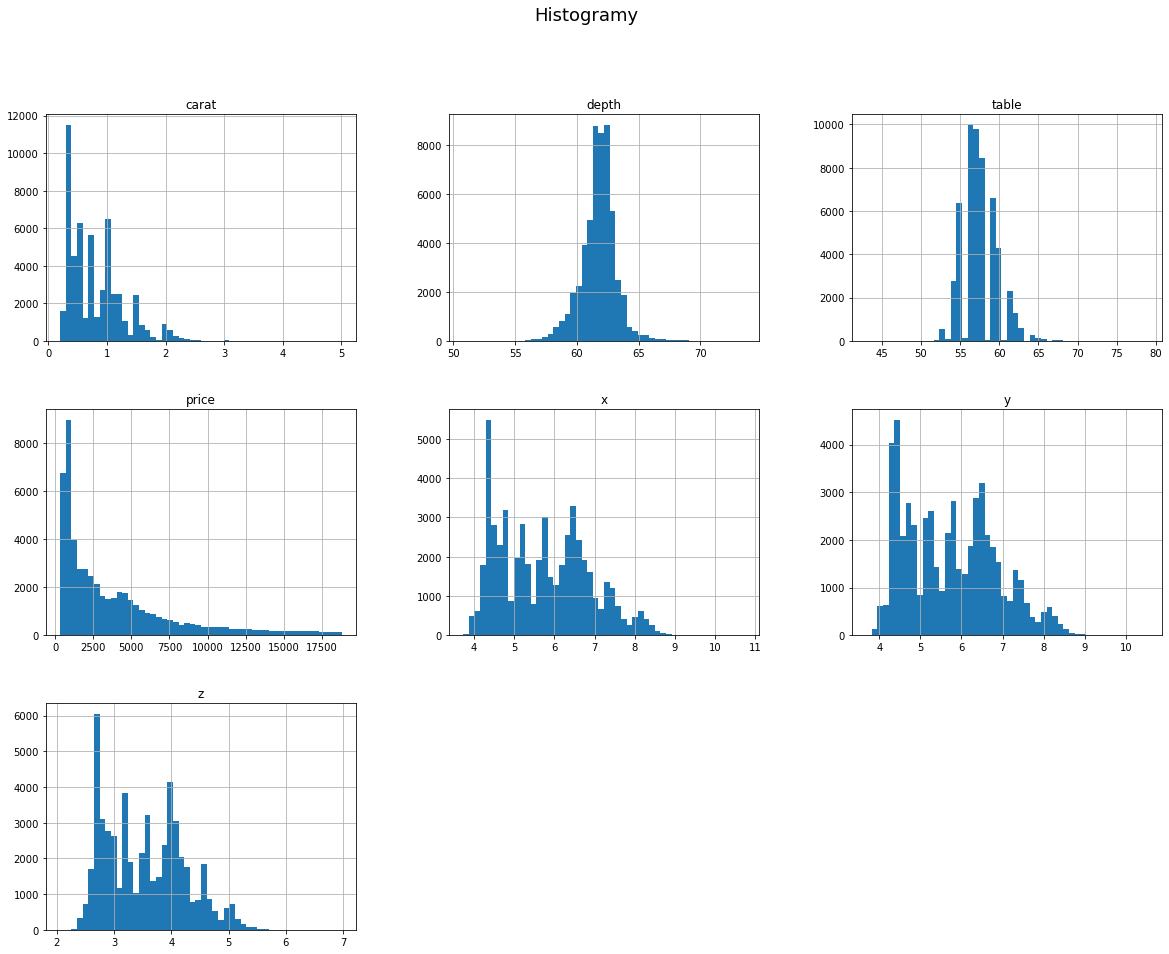

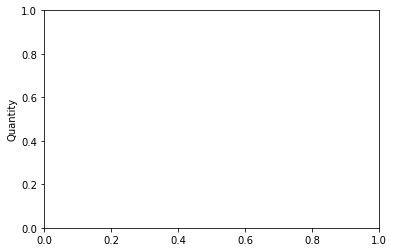

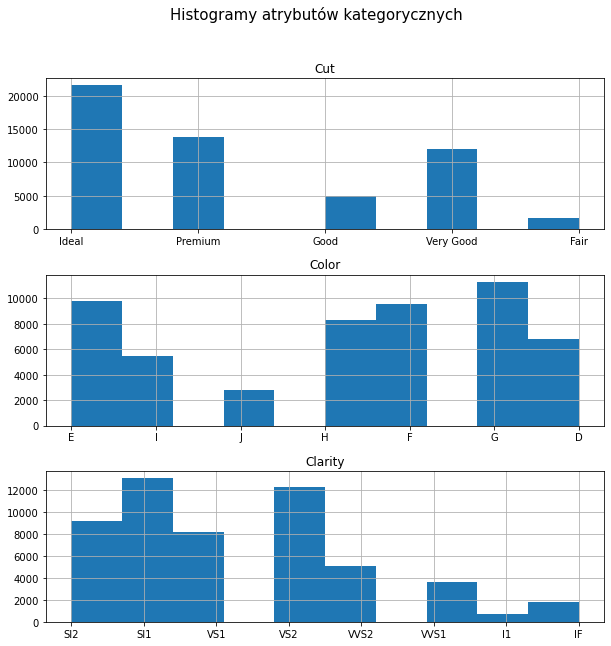

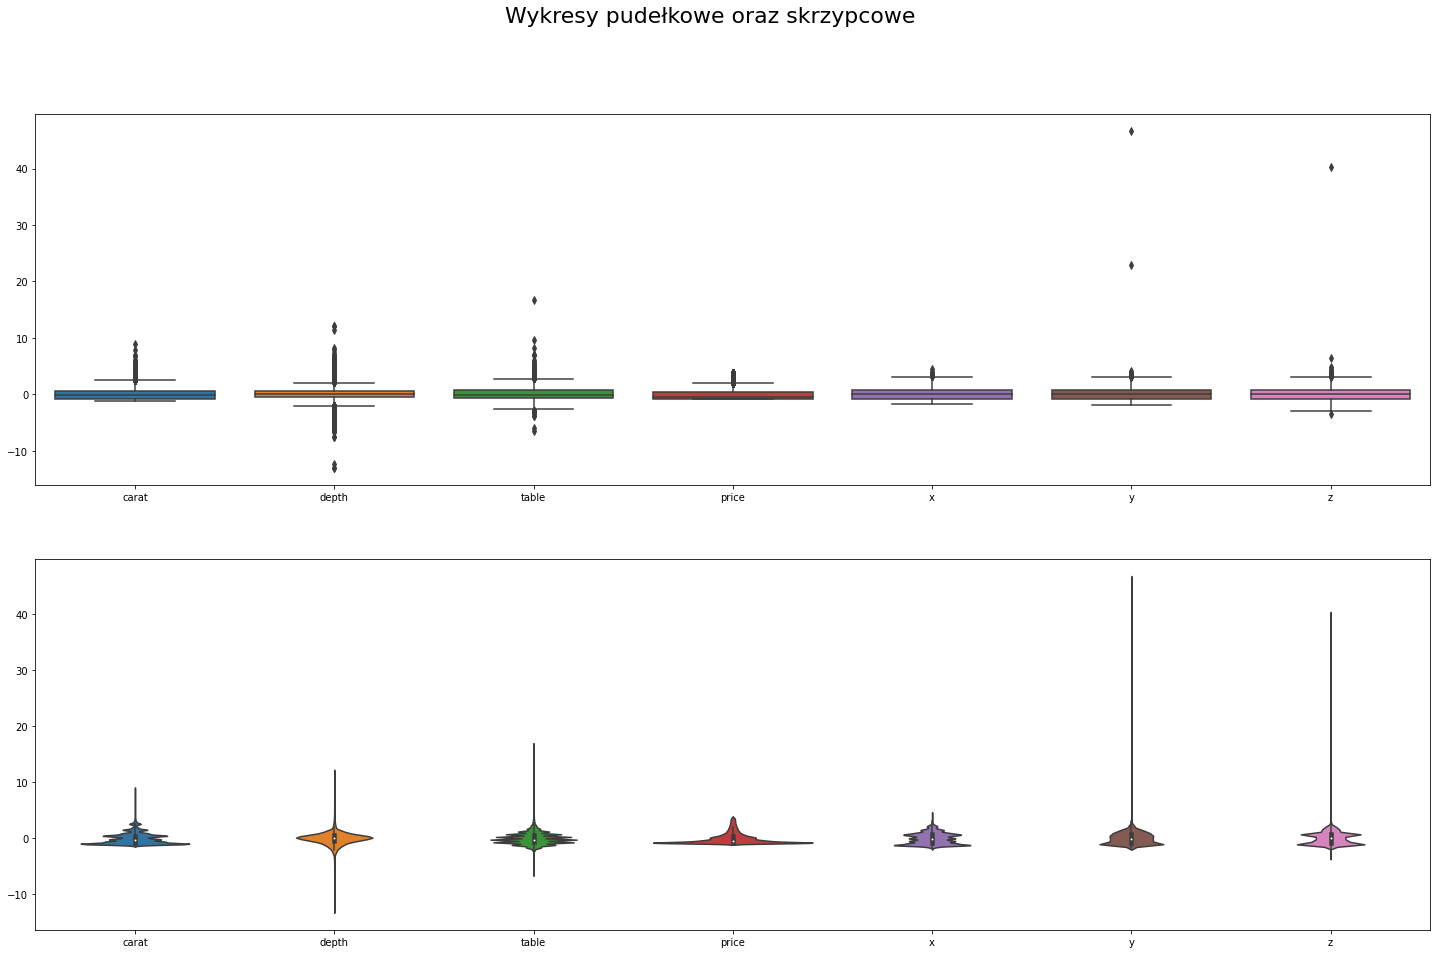

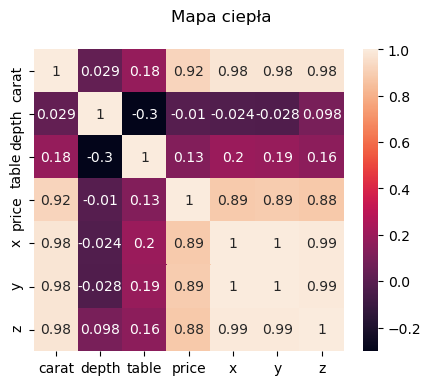

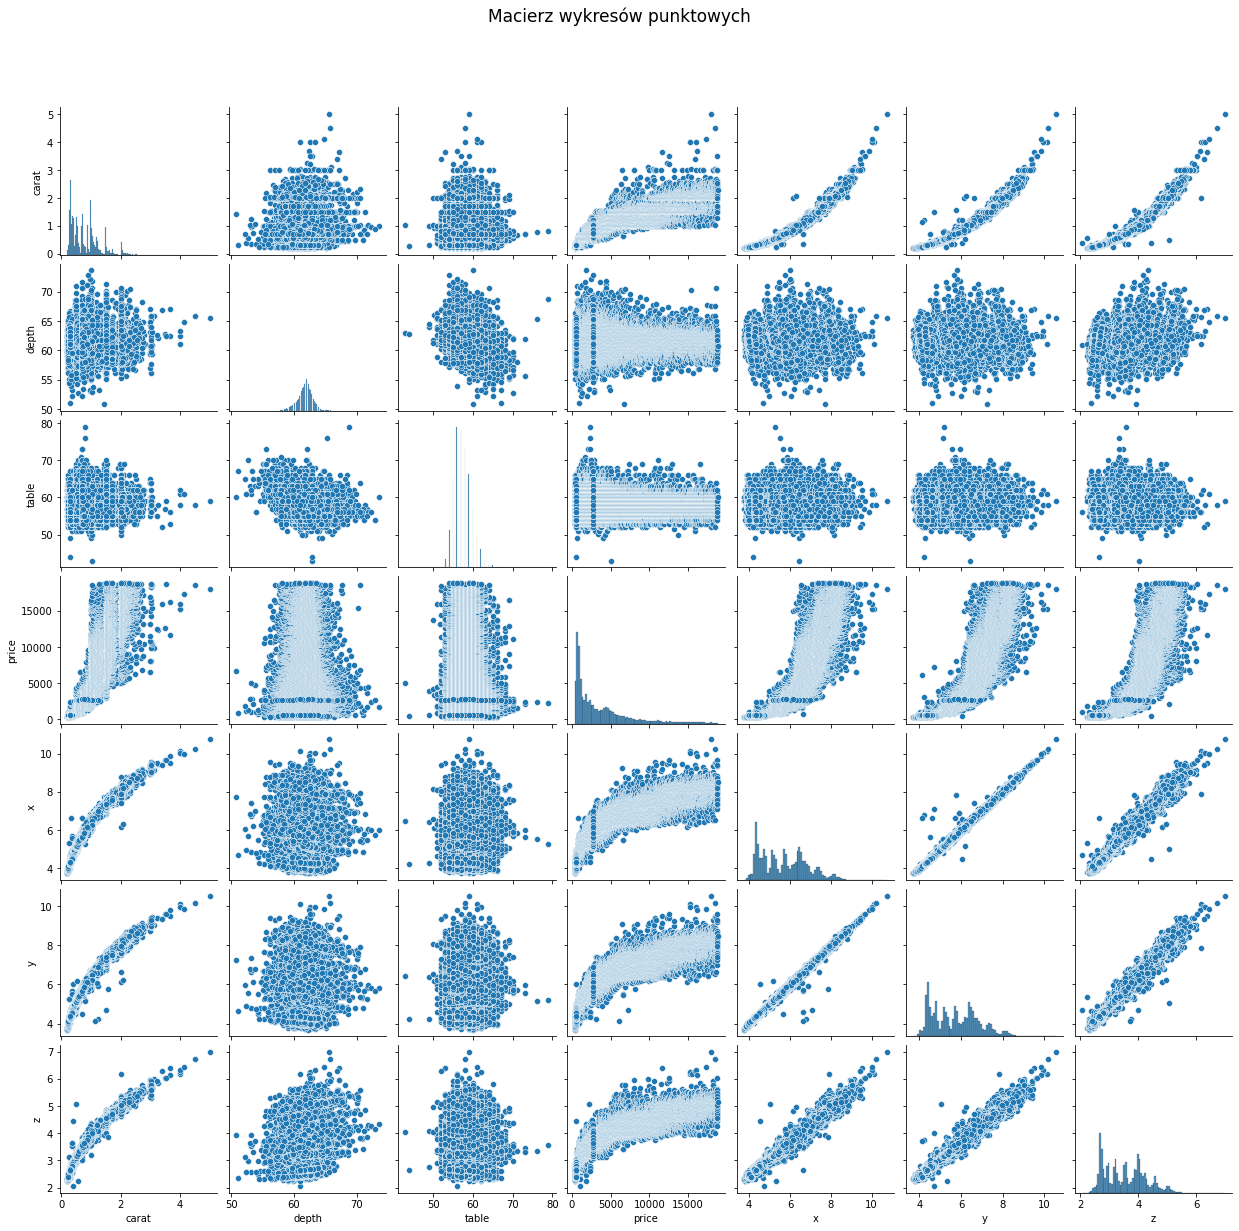

In [13]:
w2 = w.copy()
w3 = w1.copy()

w2 = w2[(w2["depth"] < 75) & (w2["depth"] > 45)]
w2 = w2[(w2["table"] < 80) & (w2["table"] > 40)]
w2 = w2[(w2["y"] < 30)]
w2 = w2[(w2["z"] < 30) & (w2["z"] > 2)]

#1 Utworzenie histogramów pojedyńczych atrybutów, aby zobaczyć rozkład danych.
w2.hist(bins = 50, figsize=(20,15))
plt.suptitle('Histogramy', size = 18)
plt.show()

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Histogramy atrybutów kategorycznych', size = 15)
plt.subplot(3,1,1)
plt.title('Cut')
w2['cut'].hist()
plt.subplot(3,1,2)
plt.title('Color')
w2['color'].hist()
plt.subplot(3,1,3)
plt.title('Clarity')
w2['clarity'].hist()

#2 Utworzenie wykresów pudełkowych oraz skrzypcowych w celu zobaczenia rozkładu atrybutów. 
plt.figure(figsize = (25, 15))
plt.suptitle('Wykresy pudełkowe oraz skrzypcowe', size = 22)
plt.subplot(2,1,1)
sns.boxplot(data = w3)
plt.subplot(2,1,2)
sns.violinplot(data = w3)

#3 Wyświetlenie mapy ciepła(korelacji), aby zobaczyć czy oraz jakie atrybuty od siebie zależą.
kor = w2.corr()
plt.figure(figsize = (5, 4), dpi = 100)
plt.suptitle('Mapa ciepła', size = 12)
sns.heatmap(kor, annot = kor)

#4 Utworzenie par wykresów, aby sprawdzić jak atrybuty się układają, czy możemy znaleźć "ogniska" oraz sprawdzenie,
# które atrybuty są bardziej, a które mniej przydatne podczas analizy.

sns.pairplot(w2, diag_kind = "hist")
plt.suptitle('Macierz wykresów punktowych', size = 17)
plt.subplots_adjust(top = 0.9)
    

**Wnioski z analizy eksploracyjnej**

Z histogramów pojedyńczych atrybutów oraz wykresów skrzypcowych i pudełkowych możemy zobaczyć jak rozkładają się poszczególne atrybuty:
* Największe rozmieszczenie atrybutu 'carat' znajduje się w okolicy wartości 0,25. Jest to rozmieszczenie nierównomierne, raczej niemożliwe do opisania za pomocą funkcji. Możemy na nim zauważyć, że znaczna większość diamentów jest o karatach w przedziale (0, 1) oraz, że bardzo mało diamentów ma więcej niż 2 karaty.
* Rozmieszczenie atrybutu 'depth' przypomina rozkład Gaussa. Można zauważyć, że znaczna większość diamentów przyjmuje wartość tego atrubutu w przedziale (60, 65) oraz, że występują nieliczne diamenty o wartościach oddalonych o ok. 20 od tego przedziału. 
* Atrybut 'table' tworzy skupisko w przedziale wartości (55, 65) i jego rozmieszczenie przypomina rozkład Gaussa. Występują nieliczne diamenty o wartościach znacznie oddalonych od przedziału skupienia.   
* Z histogramu atrybutu 'price' wynika, że najwięcej jest najtańszych diamentów w przedziale (0, 2500) i ich ilość spada wraz ze wzrostem ceny.
* Rozkłady wartości atrybutów 'x', 'y' oraz 'z' są dosyć podobne. Mają duże, nieregularne rozłożenie, atrybut 'x' oraz 'y' w przedziale wartości (0, 9), a trybut 'z' w przedziale (0, 6). Najwięcej diamentów ma wartość atrybutów 'x' oraz 'y' w przedziale (4, 5), a atrybutu 'z' w przedziale (2, 4).
* Atrybut 'cut' jest najliczniej reprezentowany przez wartość 'Ideal'. Średnia ilość diamentów przyjmuje wartośc tego atrybutu jako 'Premium' oraz 'Very Good', a najmniej ma wartość 'Good' oraz 'Fair'. Oznacza to, że diamenty w znacznej większości mają bardzo dobrą jakość szlifu.
* Wartości atrybutu 'color' rozkladają się w miarę równomierne. Jedynie wartość 'i' jest średnio liczna oraz liczba diamentów o kolorze o wartości 'j' jest znacznie mniejsza od reszty. Oznacza to, że większość diamentów ma dobry kolor, a mniejsza część ma najgorsze kolory.
* Wartości atrybutu 'clarity' rozkłądają się dosyć nierównomiernie. Najwięcej diamnetów ma wartość 'SI1', 'SI2', 'VS1' i 'VS2', czyli wartości przeciętne tego atrybutu, średnio liczne wartości to 'VVS1' oraz 'VVS2', czyli jedne z wartości najlepszych, a najmniej liczne wartości to 'IF', która jest wartością najlepszą ze wszytskich oraz 'I1', która jest wartością najgorszą. Oznacza to, że najmniej liczne wartości to wartości skrajne. 

Z mapy ciepła widzimy, że skorelowane są ze sobą wymiary (x, y, z), cena oraza karaty. Karat jest jednostką masy używanej w jubilerstwie,
więc logicznym jest, że im dany kamień ma więcej karatów, tym jest większy oraz ma wyższą cenę.
Korelacja innych atrybutów praktycznie nie zachodzi.

Z par wykresów dosyć ciężko jest wyodrębnić osobne skupiska danych. Możemy na nich zobaczyć, że aktrybuty 'carat', 'price', 'x', 'y' oraz 'z' są ze sobą
skorelowane. Natomiast połączenia tych atrybutów z pozostałymi tworzą praktycznie jedno ogromne skupisko bez szczególnie wyróżniająych się grup ze względu na to, że diamenty przyjmują dosyć ciągłe i rozłożone wartości atrybutów. Z tego powodu dane zostaną podzielone na grupy o przylegającyh wartościach granicznych.

Na podstawie powyższej analizy można stwierdzić, że najlepszymi atrybutami do grupowania diamentów będzie jeden atrybut z grupy atrybutów skorelowaych: 'carat', 'price', 'x', 'y' albo 'z' oraz dodatkowo atrybut 'depth', ponieważ rozłożenie jego wartości przypuszczalnie pozwoli na wyodrębnienie grup.


**Przygotowanie danych do grupowania**

In [4]:
w4 = w.head(25000).copy()

#1. Zmiana wartości atrybutów kategorycznych na liczbowe.

replace_map = {'cut': {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5},
               'clarity': {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2' : 6, 'VVS1' : 7, 'IF' : 8},
               'color': {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E' : 6, 'D' : 7}}

w4.replace(replace_map, inplace = True)

#2. Skalowanie danych

scaler = StandardScaler()
w5 = pd.DataFrame(scaler.fit_transform(w4))
w5.columns = w4.columns
w5.index = w4.index

print(w5.head())
w5.info()


   carat   cut  color  clarity  depth  table  price     x     y     z
0  -2.15  1.09   1.05    -1.11  -0.20  -1.24  -1.70 -2.79 -2.61 -2.81
1  -2.20  0.21   1.05    -0.44  -1.31   1.46  -1.70 -2.86 -2.76 -3.03
2  -2.15 -1.56   1.05     0.90  -3.21   3.25  -1.70 -2.68 -2.51 -3.03
3  -1.99  0.21  -1.26     0.23   0.39   0.11  -1.70 -2.51 -2.33 -2.44
4  -1.94 -1.56  -1.84    -1.11   0.98   0.11  -1.70 -2.35 -2.20 -2.22
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 25010
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    25000 non-null  float64
 1   cut      25000 non-null  float64
 2   color    25000 non-null  float64
 3   clarity  25000 non-null  float64
 4   depth    25000 non-null  float64
 5   table    25000 non-null  float64
 6   price    25000 non-null  float64
 7   x        25000 non-null  float64
 8   y        25000 non-null  float64
 9   z        25000 non-null  float64
dtypes: float64

**Omówienie przygotowania danych do grupowania**

Przed grupowaniem danych atrybuty kategoryczne zostały zamienione na liczbowe oraz wszystkie atrybuty zostały przeskalowane przy użyciu metody standaryzacji.
Zamiana atrybutów kategorycznych musiała nastąpić, aby można było je uwzględnić w obliczaniu odległości między wektorami wartości atrybutów diamentów.
Dane zostały również przeskalowane, aby wpływ każdego z atrybutów na długość wektora wartości atrybutów był równomierny. Na podstawie wcześniejszej analizy danych można było zauważyć, że atrybut 'price' przyjmuje wartości w znacznie większym zakresie niż pozostałe atrybuty, a atrybut 'carat' w mniejszym, dlatego też było to konieczne.

**Badanie grupowania diamentów metodą hierarchicznego grupowania aglomeracyjnego**

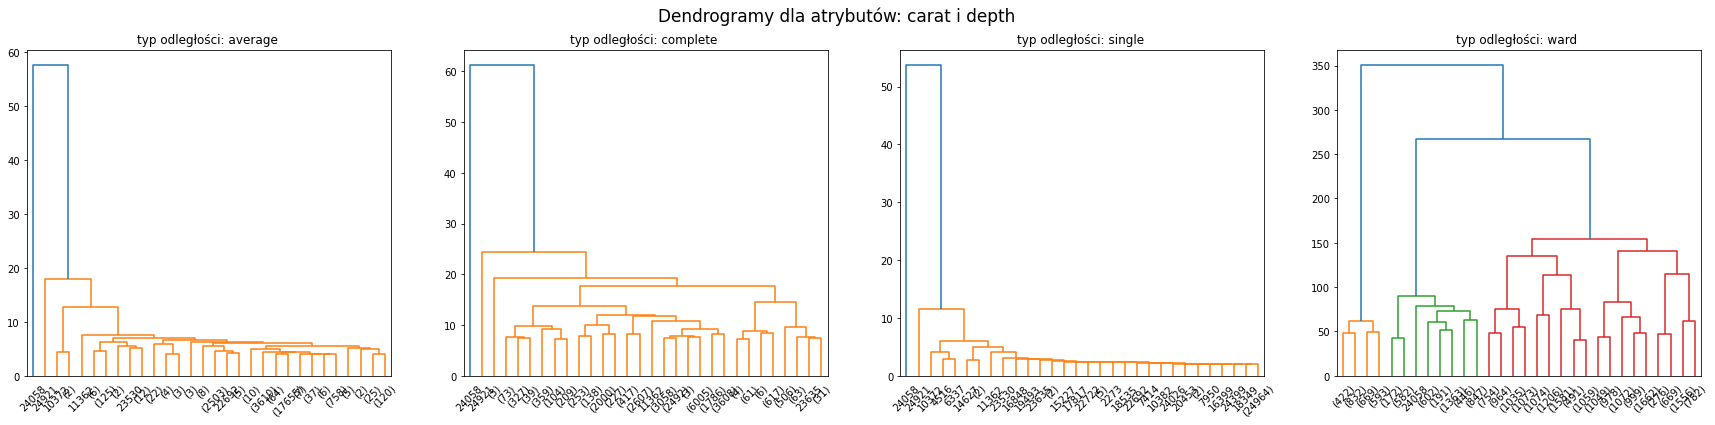

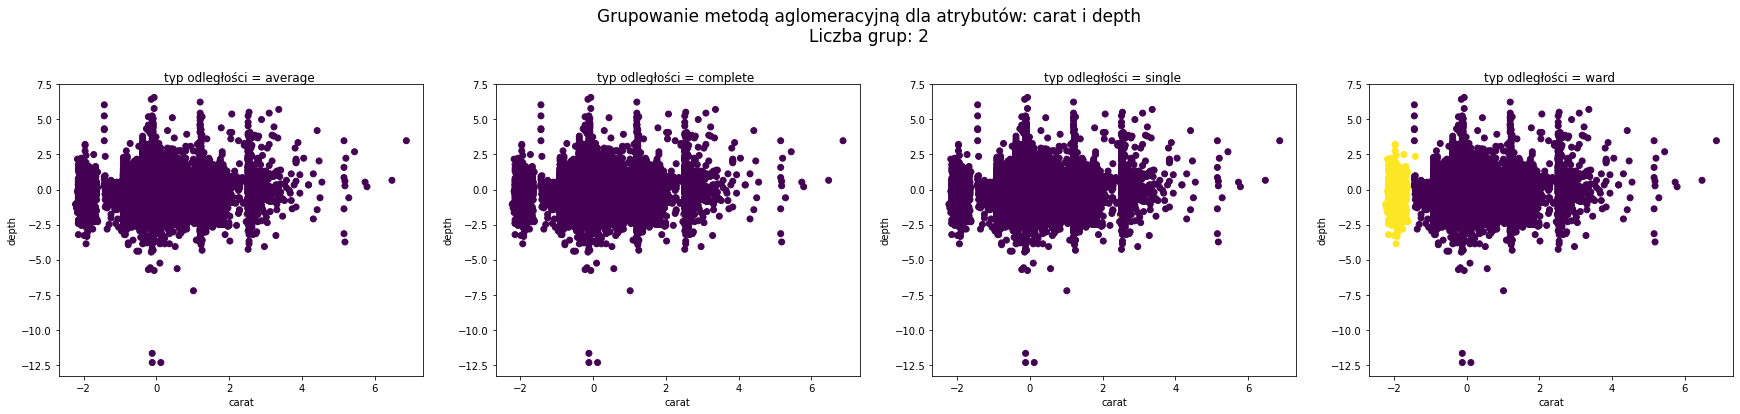

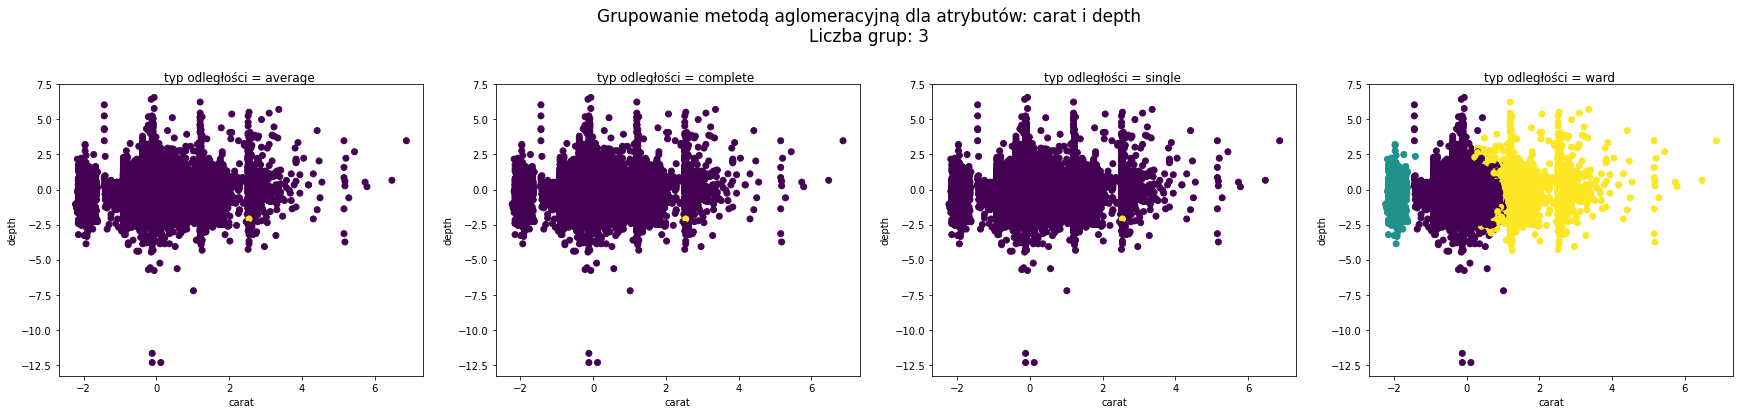

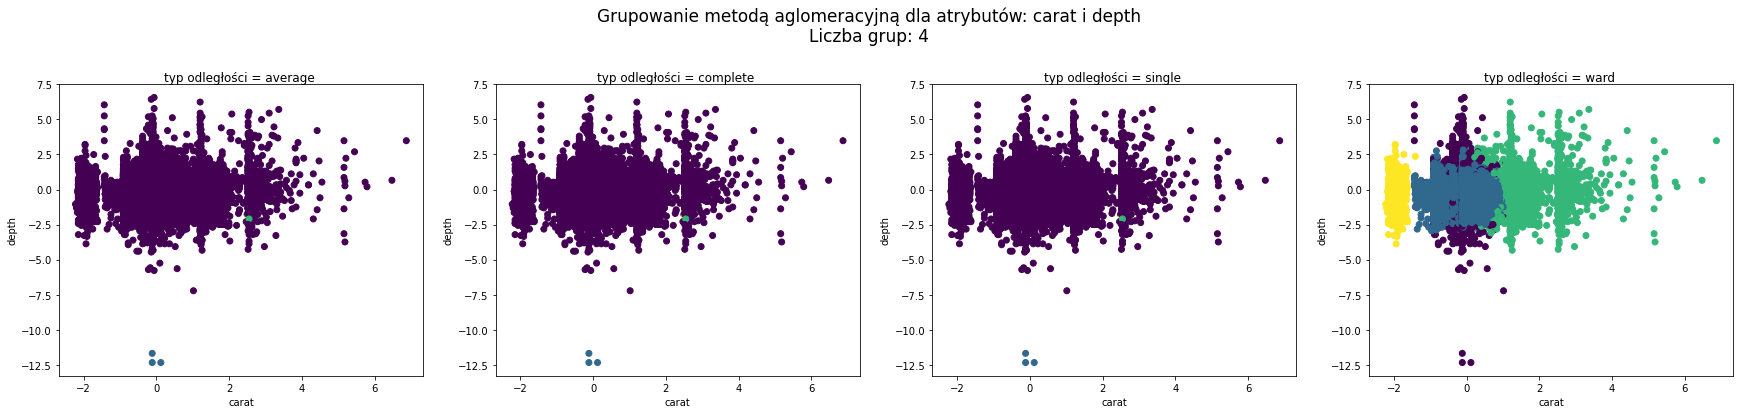

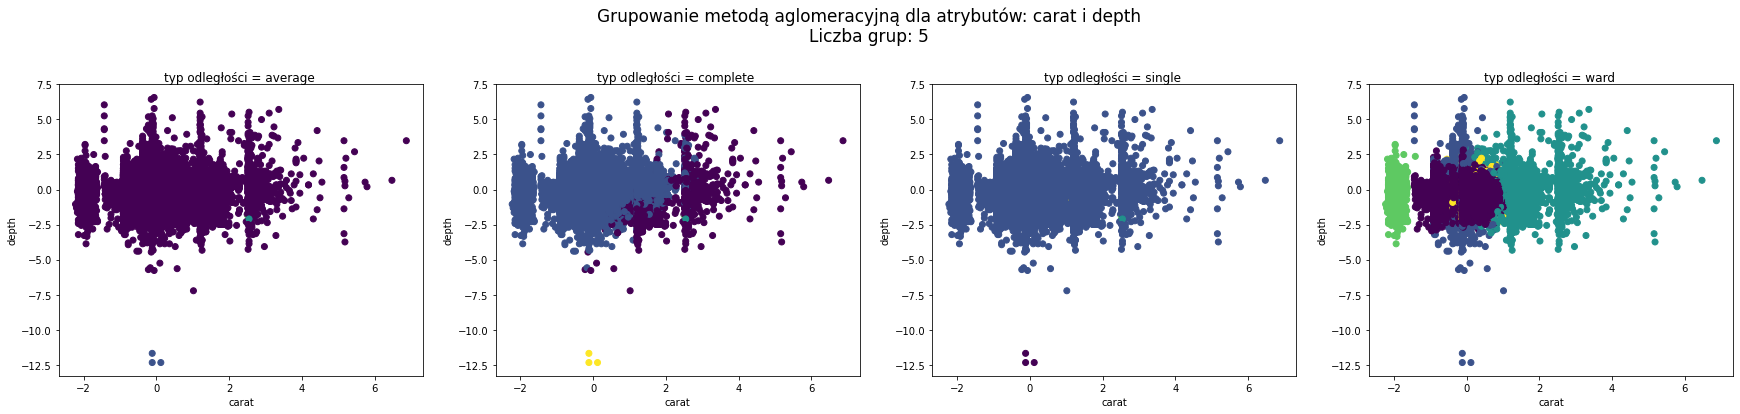

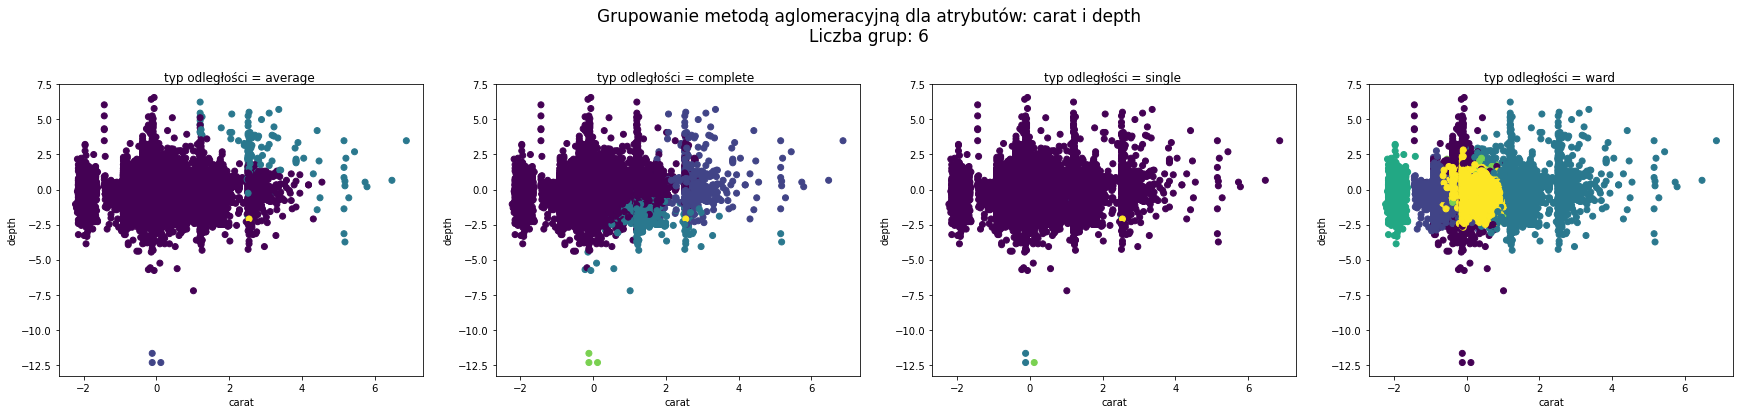

In [5]:
def pokaz_dendrogramy(df, atr1, atr2):

    plt.figure(figsize=(30, 6))

    for index, typ_odleglosci in enumerate(('average', 'complete', 'single', 'ward')):
       
        plt.subplot(1, 4, index + 1)
        grupy = linkage(df, method = typ_odleglosci, metric = 'euclidean')
        plt.suptitle('Dendrogramy dla atrybutów: {0} i {1}'.format(atr1, atr2), size = 17)
        plt.title('typ odległości: %s ' % typ_odleglosci)
        cl = dendrogram(grupy, truncate_mode = 'lastp')

def grupuj_metoda_aglomeracyjna(df, atr1, atr2, liczba_grup):

    plt.figure(figsize=(30, 6))
    for index, typ_odleglosci in enumerate(('average', 'complete', 'single', 'ward')):
        plt.subplot(1, 4, index + 1)
        model = AgglomerativeClustering(linkage = typ_odleglosci, n_clusters = liczba_grup)
        model.fit(df)
        plt.scatter(df[atr1], df[atr2], c = model.labels_)
        plt.title('typ odległości = %s ' % typ_odleglosci, fontdict=dict(verticalalignment = 'top'))
        plt.suptitle('Grupowanie metodą aglomeracyjną dla atrybutów: {0} i {1}'.format(atr1, atr2)
                     +'\nLiczba grup: {0}'.format(liczba_grup), size = 17)
        plt.subplots_adjust(top = .8, hspace = 0.3)
        plt.xlabel(atr1)
        plt.ylabel(atr2) 

pokaz_dendrogramy(w5, 'carat', 'depth')

for liczba_grup in (2,3, 4, 5, 6):
    grupuj_metoda_aglomeracyjna(w5, 'carat', 'depth', liczba_grup)


**Omówienie grupowania diamentów metodą hierarchicznego grupowania aglomeracyjnego**

Pierwsza metoda użyta do pogrupowania danych to metoda hierarchicznego grupowania aglomeracyjnego, ponieważ jest to efektywna metoda grupowania wykorzystywana  w uczeniu nienadzorowanym.

W grupowaniu danych tą metodą została wykorzystana metryka euklidesowa, ponieważ w przypadku tego zbioru, który jest bardzo zagęszczony najlepiej sprawdzi się w obliczaniu odległości między wektorami wartości atrybutów. 

Na początku dla wybranych atrybutów zostały wykonane dendrogramy, ilustrujące sposób łączenia danych w kolejne grupy. Na podstawie tych wykresów możemy zaobserować, że dla trzech pierwszych typów odległości wyróżniają się bardzo małe i gęste grupki danych połączone w jedną bardzo dużą grupę danych. Jedynie typ odległości 'ward' tworzy połączenia, na podstawie których dane można pogrupować w wyróżniające się grupy. Na podstawie dendrogramu dla typu odległości 'ward' można wywnioskować, że najlepszą liczbą grup będzie 3, ponieważ dalsze łączenia zachodzą na podstawie zbyt długich odległości.

Następnie zbadane zostało grupowanie diamentów daną metodą, dla różnej liczby grup, oraz typów odległości. Okazuje się, że wnioski wyciągnięte z dendrogramów znajdują tutaj swoje odzwierciedlenie i dane zostały najlepiej pogrupowane przy zastosowaniu typu odległości 'ward' oraz najlepsza ilość grup to 3. W grupowaniu dla atrybutów 'carat' i 'depth' możemy zauważyć, że pierwsza najmniej liczna i najbardziej skupiona grupa, przyjmuje najmniejsze wartości atrybutu 'carat' oraz średnio rozłożone wartości atrybutu 'depth'. Następna grupa większa od poprzedniej, ale również skupiona, przyjmuje średnie wartości atrybutu 'carat' oraz wartości atrybutu 'depth' z większego zakresu. Do tej grupy zostały przydzielone diamenty o najbardziej oddalonych wartościach atrybutu 'depth'. Trzecia grupa największa, najbardziej rozległa i najmniej skupiona, przyjmuje największe wartości atrybutu 'carat' oraz wartości atrybutu 'depth' z większego zakresu podobnie jak grupa 2. Na podstawie obserwacji wynika, że najwieksze znaczenie w grupowaniu miał atrybut 'carat', a atrybut 'depth' średnio przyczynił się do odróżnienia grup diamentów.

Podsumowując za pomocą metody hierarchicznego grupowania aglomeracyjnego przy użyciu metryki euklidesowej oraz typu odległości 'ward' jesteśmy w stanie pogrupować diamenty w trzy grupy o różnych wielkościach pod dominującym względem atrybutu 'carat'.

**Badanie grupowania diamentów metodą k-średnich**

<ipython-input-6-c792305cc42f>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  miara_jakosci = pd.Series()


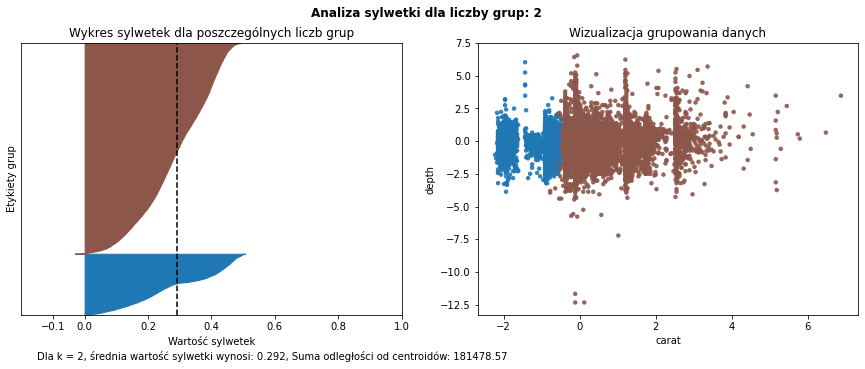

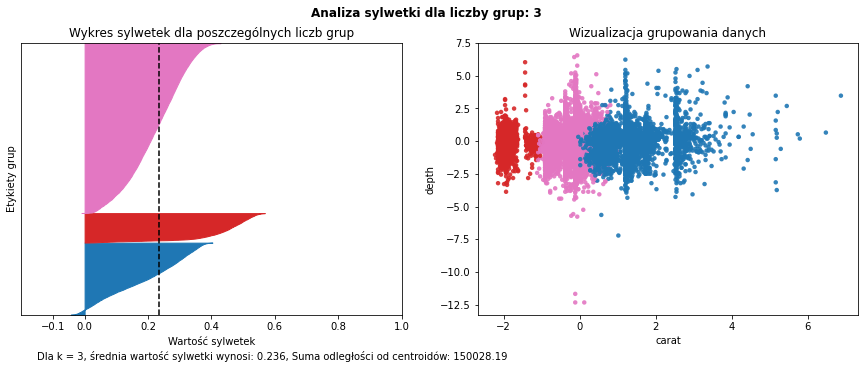

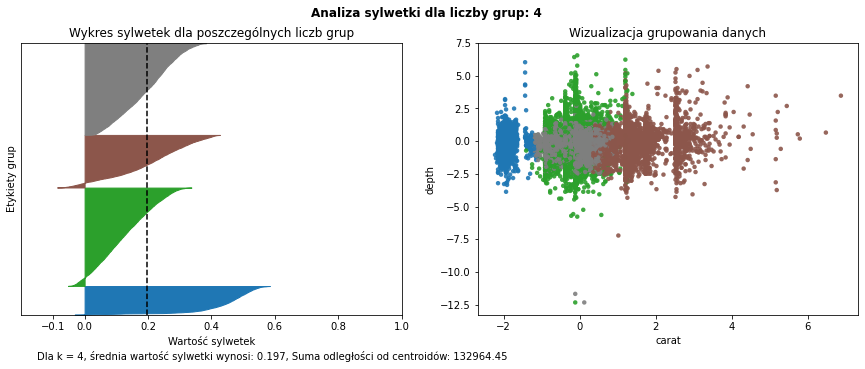

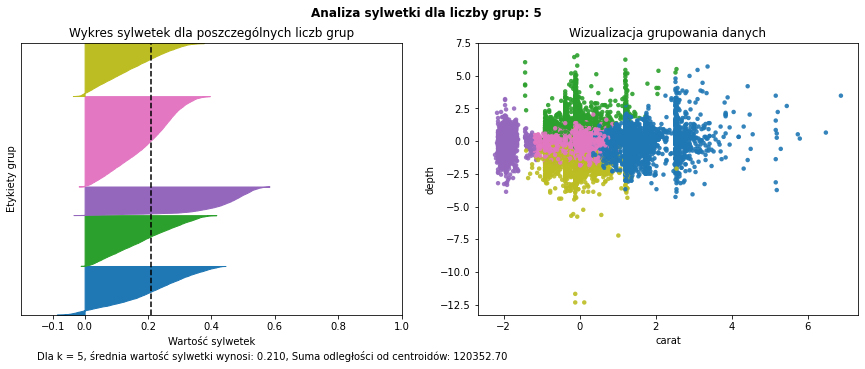

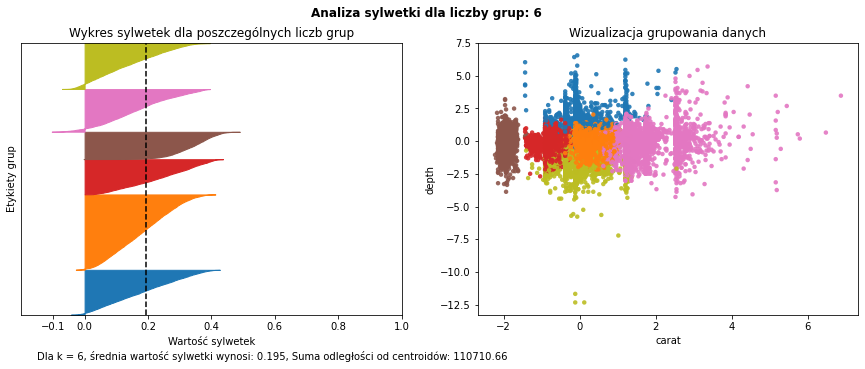

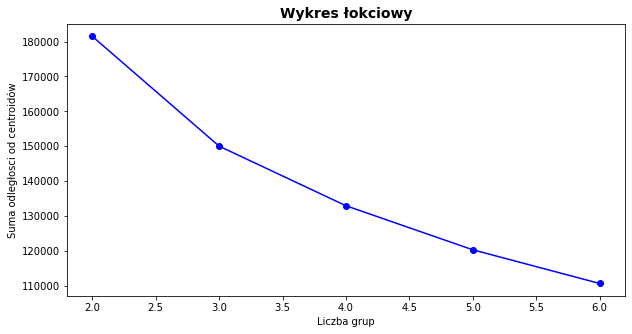

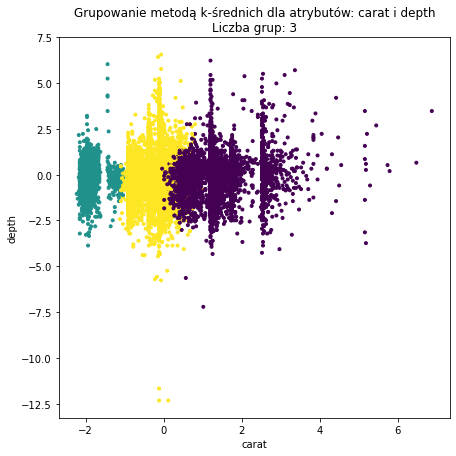

In [6]:
def wizualizuj_metode_sylwetkowa_i_lokciowa(df, zakres_k, atr1, atr2):
  
    miara_jakosci = pd.Series()

    for liczba_grup in zakres_k :
     
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(15, 5)

        ax1.set_xlim([-0.2, 1]) 
        ax1.set_ylim([0, len(df) + (liczba_grup + 1) * 10]) 
        
        kmeans = KMeans(n_clusters = liczba_grup, random_state = 0).fit(df)
        miara_jakosci = miara_jakosci.append(pd.Series(kmeans.inertia_))
        etykiety_grup = kmeans.fit_predict(df)
    
        sylwetka = silhouette_samples(df, etykiety_grup)   
        srednia_sylwetka = silhouette_score(df, etykiety_grup)
        
        pozycja_kreski = 10

        for i in range(liczba_grup):
          
            sylwetka_w_grupie = sylwetka[etykiety_grup == i]
            sylwetka_w_grupie.sort()

            liczebnosc_grupy = sylwetka_w_grupie.shape[0]
            kolor = cm.tab10(float(i) / liczba_grup)
            ax1.fill_betweenx(np.arange(pozycja_kreski, pozycja_kreski + liczebnosc_grupy), 0, sylwetka_w_grupie, color = kolor)

            pozycja_kreski += liczebnosc_grupy + 10 
            
        ax1.set_title("Wykres sylwetek dla poszczególnych liczb grup")
        ax1.set_xlabel("Wartość sylwetek")
        ax1.set_ylabel("Etykiety grup")

        ax1.axvline(x = srednia_sylwetka, color = "black", linestyle = "--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        kolory = cm.tab10(etykiety_grup.astype(float) / liczba_grup)
        ax2.scatter(df[atr1], df[atr2], marker = '.', s = 80, lw = 0, alpha = 0.9,c = kolory)

        ax2.set_title("Wizualizacja grupowania danych")
        ax2.set_xlabel(atr1)
        ax2.set_ylabel(atr2)

        plt.suptitle(("Analiza sylwetki dla liczby grup: %d" % liczba_grup),  fontweight = 'bold')
        plt.figtext(0.14, 0, ("Dla k = %d, średnia wartość sylwetki wynosi: %.3f, Suma odległości od centroidów: %.2f"
                    % (liczba_grup, srednia_sylwetka, kmeans.inertia_ ) ))
        plt.show()
        
    plt.figure(figsize=(10,5))
    plt.plot(zakres_k, miara_jakosci,'bo-')
    plt.title("Wykres łokciowy", fontsize = 14, fontweight = 'bold')
    plt.xlabel("Liczba grup")
    plt.ylabel("Suma odległosci od centroidów")

def grupuj_metoda_k_srednich(df, atr1, atr2, liczba_grup):
    
    kmeans = KMeans(n_clusters = liczba_grup, random_state = 0)
    kmeans.fit(df)
    etykiety_klastrow = kmeans.fit_predict(df)
    plt.figure(figsize = (7,7))
    plt.scatter(df[atr1], df[atr2], marker = '.', c = etykiety_klastrow)
    centroidy = kmeans.cluster_centers_
    plt.scatter(centroidy[:,0], centroidy[:,1], marker = 'x', c = np.array(range(liczba_grup)))
    plt.xlabel(atr1)
    plt.ylabel(atr2)
    plt.title('Grupowanie metodą k-średnich dla atrybutów: {0} i {1}'.format(atr1, atr2)
                     +'\nLiczba grup: {0}'.format(liczba_grup))

wizualizuj_metode_sylwetkowa_i_lokciowa(w5, range(2, 7), 'carat', 'depth')
grupuj_metoda_k_srednich(w5, 'carat', 'depth', 3)


**Omówienie grupowania diamentów metodą k-średnich**

Druga metoda użyta do pogrupowania danych to metoda k-średnich, ponieważ również jest to efektywna metoda grupowania wykorzystywana w uczeniu nienadzorowanym oraz dzięki niej uzyskamy porównanie względem grupowania hierarchicznego.

Na początku do zbadania najlepszej liczby grup zostały wykorzystane dwie metody: sylwetkowa oraz łokciowa. 

Grupowanie metodą sylwetkową zosatło wykonane dla kilku zadanych liczb grup. Na podstawie analizy wykresów mozna zauważyć, że nawiększa wartość średnia miary sylwetki, czyli wtedy kiedy jak najwięcej obiektów leży jak najbliżej odpowiadających im centroidów, jest dla liczby grup równej 2 oraz 3.

Na podstawie wykonanego wykresu łokciowego można stwierdzić, że najbardziej optymalną liczbą grup będą 3 grupy, ponieważ dla liczby 3 wykres jest najbardziej załamany. Wykres ten jednak nie daje nam jednoznacznej odpowiedzi, ponieważ różnice załamań wiodoczne na wykresie dla różnej liczby grup są minimalne. 

Na podstawie analizy powyższych metod można uznać, że najbardziej optymalną liczbą grup jest liczba 3.

Następnie zostało przeprowadzone grupowanie diamentów daną metodą dla atrybutów 'carat' oraz 'depth' dla ustalonej liczby grup. Możemy zauważyć, że pierwsza grupa najmniej liczna składa się z dwóch oddzielnych bardziej skupionych grupek i przyjmuje najmniejsze wartości atrybutu 'carat' oraz średnio rozłożone wartości atrybutu 'depth'. Następna grupa większa od poprzedniej, ale również skupiona, przyjmuje średnie wartości atrybutu 'carat' oraz wartości atrybutu 'depth'z większego zakresu. Do tej grupy zostały przydzielone diamenty o najbardziej oddalonych wartościach atrybutu 'depth'. Trzecia grupa, któa zachodzi na grupę drugą, jest największa, najbardziej rozległa i najmniej skupiona, przyjmuje największe wartości atrybutu 'carat' oraz wartości atrybutu 'depth'z większego zakresu podobnie jak grupa 2. Na podstawie obserwacji wynika, że najwieksze znaczenie w grupowaniu miał atrybut 'carat', a atrybut 'depth' średnio przyczynił się do odróżnienia grup diamentów.

Podsumowując za pomocą metody k-średnich jesteśmy w stanie pogrupować diamenty w trzy grupy o różnych wielkościach pod dominującym względem atrybutu 'carat'.

**Wnioski końcowe**

Na podstawie analizy metody hierarchicznego grupowania aglomeracyjnego oraz metody k-średnich można stwierdzić, że najbardziej optymalną liczbą grup, na które można podzielić diamenty jest liczba 3. W przypadku pierwszej omawianej metody podział na grupy był jednak bardziej konretny i sensowny niż w przypadku drugiej metody, ponieważ metoda k-średnich przeciągnęła i nałożyła grupę pierwszą i trzecią na grupę drugą. Wynika to prawdopodobnie z faktu, że metoda k-średnich nie działa za dobrze w przypadku wydłużonych kształtów klastrów, a takie właśnie mamy. Podział na grupy nastąpił głównie ze względy na wartośc atrybutu 'carat', a to oznacza, że diamenty najłatwiej odróżnić na podstawie jednego ze skorelowanych ze sobą atrybutów: 'carat', 'price', 'x', 'y' albo 'z'. Natomiast na podstawie atrybutów 'depth', czy 'table' nie da się wyróżnić grup diamentów.


**Przewidywanie cen diamentów na podstawie różnych atrybutów z wykorzystaniem metody regresji liniowej**

Text(0.5, 1.0, "Regresja liniowa : Price(cena) na podstawie atrybutu 'x'")

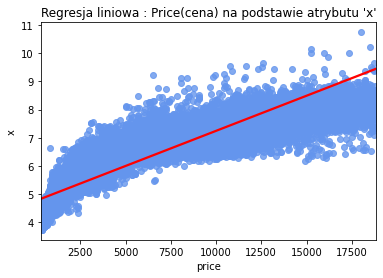

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

d = w.copy()

replace_map_d = {'cut': {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5},
               'clarity': {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2' : 6, 'VVS1' : 7, 'IF' : 8},
               'color': {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E' : 6, 'D' : 7}}

d.replace(replace_map_d, inplace = True)
d = d[(d["depth"]<75)&(d["depth"]>45)]
d = d[(d["table"]<80)&(d["table"]>40)]
d = d[(d["y"]<30)]
d = d[(d["z"]<30)&(d["z"]>2)]

linearReg_forX = sns.regplot(x = "price", y = "x", data = d, fit_reg = True,
                             scatter_kws = {"color": "cornflowerblue"}, line_kws = {"color": "red"})
linearReg_forX.set_title("Regresja liniowa : Price(cena) na podstawie atrybutu 'x'", color = "black")

Text(0.5, 1.0, "Regresja liniowa : Price(cena) na podstawie atrybutu 'y'")

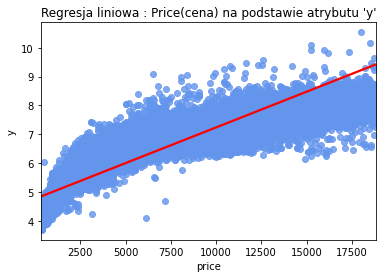

In [8]:
linearReg_forY = sns.regplot(x = "price", y = "y", data = d, fit_reg = True,
                             scatter_kws = {"color": "cornflowerblue"}, line_kws = {"color": "red"})
linearReg_forY.set_title("Regresja liniowa : Price(cena) na podstawie atrybutu 'y'", color = "black")

Text(0.5, 1.0, "Regresja liniowa : Price(cena) na podstawie atrybutu 'z'")

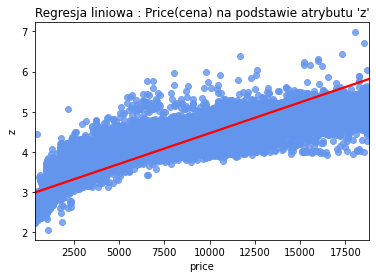

In [9]:
linearReg_forZ = sns.regplot(x = "price", y = "z", data = d, fit_reg = True,
                             scatter_kws = {"color": "cornflowerblue"}, line_kws = {"color": "red"})
linearReg_forZ.set_title("Regresja liniowa : Price(cena) na podstawie atrybutu 'z'", color = "black")

Text(0.5, 1.0, "Regresja liniowa : Price(cena) na podstawie atrybutu 'carat'")

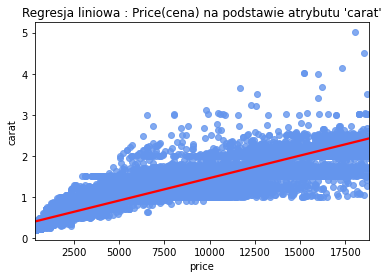

In [10]:
linearReg_forCarat = sns.regplot(x = "price", y = "carat", data = d, fit_reg = True,
                             scatter_kws = {"color": "cornflowerblue"}, line_kws = {"color": "red"})
linearReg_forCarat.set_title("Regresja liniowa : Price(cena) na podstawie atrybutu 'carat'", color = "black")

Text(0.5, 1.0, "Regresja liniowa : Price(cena) na podstawie atrybutu 'table'")

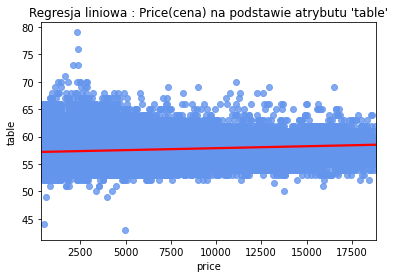

In [11]:
linearReg_forTable = sns.regplot(x = "price", y = "table", data = d, fit_reg = True,
                             scatter_kws = {"color": "cornflowerblue"}, line_kws = {"color": "red"})
linearReg_forTable.set_title("Regresja liniowa : Price(cena) na podstawie atrybutu 'table'", color = "black")

Text(0.5, 1.0, "Regresja liniowa : Price(cena) na podstawie atrybutu 'depth'")

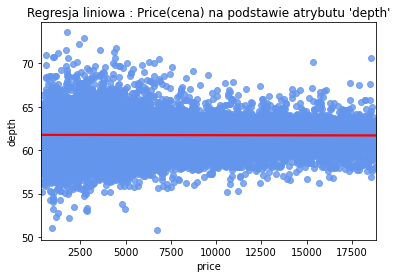

In [12]:
linearReg_forDepth = sns.regplot(x = "price", y = "depth", data = d, fit_reg = True,
                             scatter_kws = {"color": "cornflowerblue"}, line_kws = {"color": "red"})
linearReg_forDepth.set_title("Regresja liniowa : Price(cena) na podstawie atrybutu 'depth'", color = "black")

Średni błąd bezwzględny:  789.5908898128345
Średni błąd kwadratowy:  1390401.2082389973
Procentowy średni błąd bezwzględny:  41.82 %
Dokładność:  58.18 %


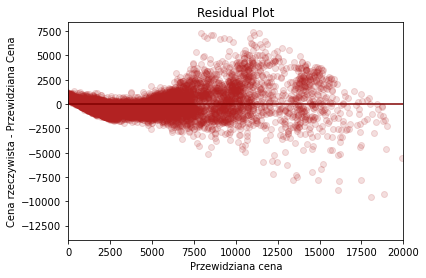

In [13]:
def printMetrics(y_test, predictions):
    mae = metrics.mean_absolute_error(y_test, predictions)
    mse = metrics.mean_squared_error(y_test, predictions)
    mape = np.mean(np.abs(y_test - predictions) / np.abs(y_test))
    
    print('Średni błąd bezwzględny: ', mae)
    print('Średni błąd kwadratowy: ', mse)
    print('Procentowy średni błąd bezwzględny: ', round(mape * 100, 2), '%')
    print('Dokładność: ', round(100 * (1 - mape), 2), '%')

def residualPlotConstructor(y_test, predictions, a, c1, c2):
    fig, ax = plt.subplots()
    ax.set(xlabel = 'Przewidziana cena', ylabel = 'Cena rzeczywista - Przewidziana Cena', title = 'Residual Plot')
    ax.scatter(predictions, y_test - predictions, alpha = a, color = c1)
    ax.axhline(y = 0, color = c2)
    ax.set_xlim(right = 20000)
    ax.set_xlim(left = 0)
    
Y = d['price']
X = d.drop('price', axis = 1)

atrybuty = d.columns.tolist()

X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.2)

lr = LinearRegression()
lr.fit(X_train,Y_train)
    
predictions = lr.predict(X_test)
printMetrics(Y_test, predictions)
residualPlotConstructor(Y_test, predictions, 0.15, 'firebrick', 'maroon')

**Wnioski z przewidywania cen diamentów na podstawie różnych atrybutów z wykorzystaniem metody regresji liniowej**
    
Jak widać na wykresach regresji liniowej wraz ze wzrostem wartości poszczególnych atrybutów cena najczęściej także rośnie. Poprzez obserwację wykresów można wywnioskować iż największy udział w ustalaniu przewidywanej ceny mają takie atrybuty jak:
* rozmiary, czyli parametry : 'x' , 'y' , 'z'
* waga diamentu, czyli atrybut : 'carat'

Atrybuty 'depth' oraz 'table' nie mają zbyt zauważalnego samodzielnego wpływu na cenę diamentów.

Na powyższym wykresie "Residual Plot" można zauważyć dokładność z jaką regresja liniowa przewiduje cenę.
Dla niskich cen przewidywania są naprawdę całkiem bliskie rzeczywistym cenom natomiast wyższe wartości przewidzianych cen są już mniej trafne i potrafią odbiegać dosyć daleko od oczekiwanego wyniku.

Jak widać regresja liniowa ma dokładność zaledwie 56.15%, co zdecydowanie nie jest zadowalającym wynikiem.
Wnioskiem z tego jest to, że regresja liniowa nie jest najlepszą metodą regresji w tym przypadku, czyli do przewidywania cen diamentów. Warto jednak było zbadać jak sprawdza się ona w takim zadaniu. O wiele lepszą metodą okazałaby się np.RanndomForestRegressor

**Podsumowanie projektu**

Projekt został zrealizowany z podziałem zadań między członków zespołu. Każdy z nas zajmował się jednym z etapów przeprowadzenia zadania projektowego oraz wszyscy formułowali wspólnie wnioski. Postępy prac były wrzucane do repozytorium w serwisie GitHub. Główne zadanie projektowe na zbiorze danych 'Diamenty', czyli grupowanie diamentów zostało przeprowadzone na podstawie dwóch różnych metod grupowania z dziedziny uczenia nienadzorowanego, co pozwoliło nam na poszerzenie umiejętności z tego obszaru. Dodatkowo zrealizowane zostało przewidywanie cen diamentów na podstawie różnych atrybutów z wykorzystaniem metody regresji liniowej, co również pozwoliło nam na rozwój w dziedzinie analizy danych. 
